## Import Library

In [16]:
%matplotlib notebook
import random
import sys
import numpy as np
import scipy
import scipy.spatial
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec
# import seaborn as sns
import time
import csv
import math
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from PIL import Image


In [17]:
def read_img():
    im = Image.open("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/20191022/map_r1.pgm")
    im.show()
    print(im.size)
    return im
# im = read_img()

## Loading Data

In [130]:
my_data_x = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/20191025/mag_data_x.csv', delimiter=',')
my_data_y = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/20191025/mag_data_y.csv', delimiter=',')
my_data_z = np.genfromtxt('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/20191025/mag_data_z.csv', delimiter=',')


# Load MagImage for deciding that where the data is and getting the width and Height of map
def load_image( infilename ) :
    img = Image.open( infilename )
    img.load()
    data = np.asarray( img, dtype="int32" )
    return data
gray_img = load_image('/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/20191025/mag_map.png')
(g_height,g_width, channel_size)=gray_img.shape

ground_truth_mag_img_x = np.zeros([g_height, g_width])
ground_truth_mag_img_y = np.zeros([g_height, g_width])
ground_truth_mag_img_z = np.zeros([g_height, g_width])

data_xy = []
data_z = []

max_value = -99
min_value = 99
abs_min_value = 99

mean_x = 0;
mean_y = 0;
mean_z = 0;

for i in range(g_height):
    for j in range(g_width):
        if gray_img[i][j][0]!=0.0:
            if my_data_x[i][j]>max_value:
                max_value = my_data_x[i][j]
            if my_data_y[i][j]>max_value:
                max_value = my_data_y[i][j]
            if my_data_z[i][j]>max_value:
                max_value = my_data_z[i][j]
                
            if my_data_x[i][j]<min_value:
                min_value = my_data_x[i][j]
            if my_data_y[i][j]<min_value:
                min_value = my_data_y[i][j]
            if my_data_z[i][j]<min_value:
                min_value = my_data_z[i][j]
            
            if abs(my_data_x[i][j])<abs_min_value:
                abs_min_value = abs(my_data_x[i][j])
            if abs(my_data_y[i][j])<abs_min_value:
                abs_min_value = abs(my_data_y[i][j])
            if abs(my_data_z[i][j])<abs_min_value:
                abs_min_value = abs(my_data_z[i][j])
                
#             Generate Ground Truth Image
            ground_truth_mag_img_x[i][j] = my_data_x[i][j]
            ground_truth_mag_img_y[i][j] = my_data_y[i][j]
            ground_truth_mag_img_z[i][j] = my_data_z[i][j]
            
#             Generate training data vec(x,y) & vec(z)
            m_mag_vec = []
            m_mag_vec.append((my_data_x[i][j]+10)*2)
            m_mag_vec.append((my_data_y[i][j]+10)*2)
            m_mag_vec.append((my_data_z[i][j]+10)*2)
            data_xy.append([j*0.05-3.176096, i*0.05-5.051761]) # (width, height)
#             data_xy.append([j, i]) # (width, height)
            data_z.append(m_mag_vec)

data_xy = np.asarray(data_xy)
data_z = np.asarray(data_z)
data_size = data_z.shape[0]
# print('abs minimal value: ', abs_min_value)

In [131]:
# Shuffle data
data = np.concatenate((data_xy, data_z), axis=1)
np.random.shuffle(data)
data_xy, data_z = np.array_split(data, [2], axis=1)

# Seperate data to training part and verify part 
# tmp_size = int(mag_training_data_xy.shape[0]*0.3)
# mag_training_data_xy, mag_verify_data_xy = np.array_split(mag_training_data_xy, [tmp_size], axis=0)
# mag_training_data_z, mag_verify_data_z = np.array_split(mag_training_data_z, [tmp_size], axis=0)

mag_training_data_xy = []
mag_training_data_z = []
mag_verify_data_xy = []
mag_verify_data_z = []
training_data_size = 0

def calculate_dist(p1, p2):
    return math.hypot(p1[0]-p2[0], p1[1]-p2[1])

suitible_flag = False

for i in range(data_size):
    if training_data_size==0:
        mag_training_data_xy.append(data_xy[i])
        mag_training_data_z.append(data_z[i])
        training_data_size = training_data_size+1
    else:
        for j in range(training_data_size):
            if calculate_dist(data_xy[i], mag_training_data_xy[j]) < 0.15:
                break
            if j==training_data_size-1:
                suitible_flag = True
        if suitible_flag:
            mag_training_data_xy.append(data_xy[i])
            mag_training_data_z.append(data_z[i])
            training_data_size = training_data_size+1
            suitible_flag = False
        else:
            mag_verify_data_xy.append(data_xy[i])
            mag_verify_data_z.append(data_z[i])

mag_training_data_xy = np.asarray(mag_training_data_xy)
mag_training_data_z = np.asarray(mag_training_data_z)
mag_verify_data_xy = np.asarray(mag_verify_data_xy)
mag_verify_data_z = np.asarray(mag_verify_data_z)

In [132]:
print(mag_training_data_xy.shape)
print(mag_verify_data_xy.shape)
print(data_size)

(646, 2)
(4919, 2)
5565


## Define Functions may used later

In [133]:
def training_gp(training_xy, training_z):
    kernel = C(0.1, (1e-2, 1e2)) * RBF(10, (1e-2, 1e2))
    gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)

    start_time = time.time()
    gp.fit(training_xy, training_z)
    print("---Training Time: %s seconds ---" % (time.time() - start_time))
    return gp

def pred_gp(gp, test_xy):
    start_time = time.time()
    y_pred, sigma = gp.predict(test_xy, return_std=True)
    print("--- Predict Time:  %s seconds ---" % (time.time() - start_time))
    y_pred = y_pred/2-10
    return y_pred, sigma

def generate_test_data(training_xy):
    test_data_range_x =np.linspace(0, g_width-1, g_width)
    test_data_range_y =np.linspace(0, g_height-1, g_height)
    
    test_xy = np.zeros([g_width*g_height,2])
    for m in range(g_height):
        for n in range(g_width):
            test_xy[m*g_width+n][0] = test_data_range_x[n]*0.05-3.176096
            test_xy[m*g_width+n][1] = test_data_range_y[m]*0.05-5.051761
    return test_xy, g_width, g_height

def mark_unknown_area(OneD_pred_map, mark_value):
    output = np.zeros(0)

    for i in range(g_height):
        for j in range(g_width):
            if gray_img[i][j][0] ==0.0:
                output = np.append(output, mark_value-0.5)
            else:
                output = np.append(output, OneD_pred_map[i*g_width+j])
    return output
    
def show_predic(test_xy, pred_z,m_axis):
    fig, ax = plt.subplots()
    _min = min_value
    _max = max_value
    sc = plt.scatter(test_xy[:,0], test_xy[:,1], c=pred_z, cmap='rainbow', vmin = _min, vmax = _max)
    # plt.plot(mag_training_data_xy[:,0], mag_training_data_xy[:,1], 'ko')
    # for i in range(len(mag_training_data_z)):
    #     ax.annotate(np.round(mag_training_data_z[i],3), xy=(mag_training_data_xy[i][0],mag_training_data_xy[i][1]), color='black', 
    #             xytext=(5,5), textcoords="offset points")
    file_path = "/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/"
    filename = file_path+"scikit_GP_result_"+m_axis
    plt.colorbar()
    plt.savefig(filename)
    plt.show()

## Deploy

In [140]:
test_xy, data_x_size, data_y_size = generate_test_data(mag_training_data_xy)

gp_x = training_gp(mag_training_data_xy, mag_training_data_z[:,0])
gp_y = training_gp(mag_training_data_xy, mag_training_data_z[:,1])
gp_z = training_gp(mag_training_data_xy, mag_training_data_z[:,2])

# # fig, ax = plt.subplots()
# # _min, _max = np.amin(mag_training_data_z), np.amax(mag_training_data_z)
# # sc = plt.scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zz, cmap='rainbow', vmin = _min, vmax = _max)
# # plt.colorbar()



---Training Time: 0.835770845413208 seconds ---
---Training Time: 1.5351660251617432 seconds ---
---Training Time: 1.7332656383514404 seconds ---


In [141]:
# for Drawing
mag_x_pred, mag_x_sigma = pred_gp(gp_x, test_xy)
mag_y_pred, mag_y_sigma = pred_gp(gp_y, test_xy)
mag_z_pred, mag_z_sigma = pred_gp(gp_z, test_xy)

my_draw_test_data_x = test_xy[:,0].reshape(data_x_size*data_y_size,1)
my_draw_test_data_y = test_xy[:,1].reshape(data_x_size*data_y_size,1)
my_test_predict_zx = mag_x_pred.reshape(data_x_size*data_y_size,1)
my_test_predict_zy = mag_y_pred.reshape(data_x_size*data_y_size,1)
my_test_predict_zz = mag_z_pred.reshape(data_x_size*data_y_size,1)

--- Predict Time:  0.26096558570861816 seconds ---
--- Predict Time:  0.2701447010040283 seconds ---
--- Predict Time:  0.28972744941711426 seconds ---


<IPython.core.display.Javascript object>


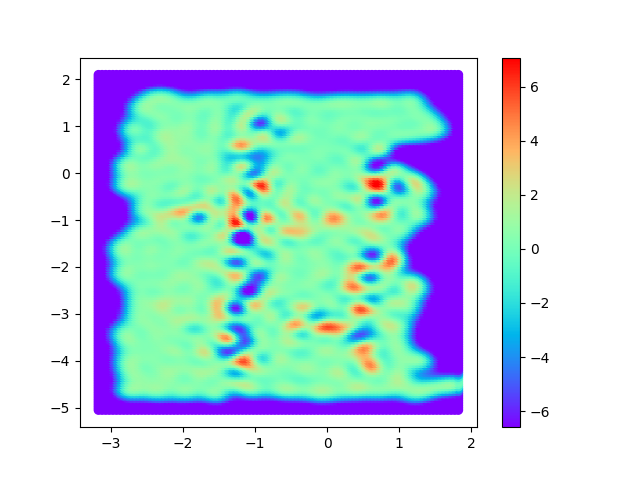

<IPython.core.display.Javascript object>


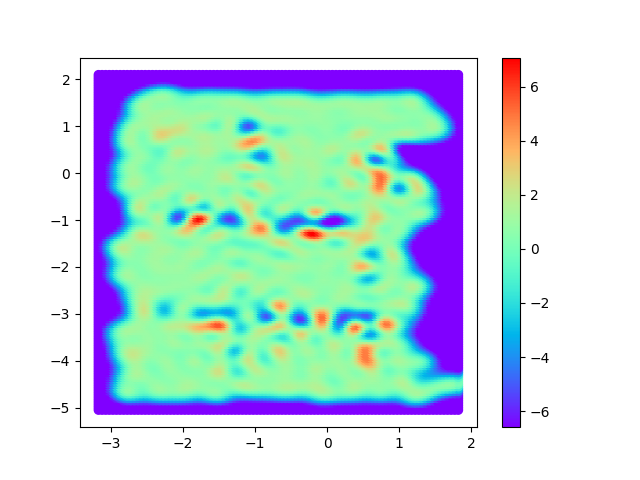

<IPython.core.display.Javascript object>


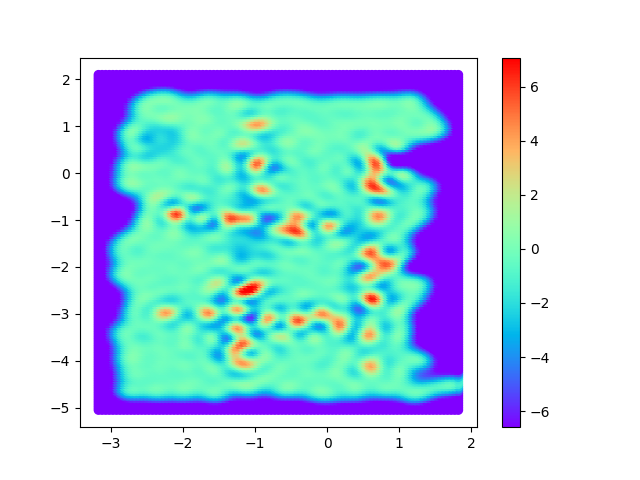

In [142]:
# f, axes = plt.subplots(nrows = 1, ncols = 3, sharex=True, sharey = True)
# _min, _max = np.amin(my_test_predict_zx), np.amax(my_test_predict_zx)
# sc = axes[0].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zx, cmap='rainbow', vmin = _min, vmax = _max)
# _min, _max = np.amin(my_test_predict_zy), np.amax(my_test_predict_zy)
# axes[1].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zy, cmap='rainbow', vmin = _min, vmax = _max)
# _min, _max = np.amin(my_test_predict_zz), np.amax(my_test_predict_zz)
# axes[2].scatter(my_draw_test_data_x, my_draw_test_data_y, c=my_test_predict_zz, cmap='rainbow', vmin = _min, vmax = _max)
# f.colorbar(sc)
show_predic(test_xy, mag_x_pred, 'x')
show_predic(test_xy, mag_y_pred, 'y')
show_predic(test_xy, mag_z_pred, 'z')

In [145]:
# for Verifying
mag_x_pred, mag_x_sigma = pred_gp(gp_x, mag_verify_data_xy)
mag_y_pred, mag_y_sigma = pred_gp(gp_y, mag_verify_data_xy)
mag_z_pred, mag_z_sigma = pred_gp(gp_z, mag_verify_data_xy)

from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(mag_verify_data_z[:,0]/2-10, mag_x_pred) 
print("x: ", MSE)
MSE = mean_squared_error(mag_verify_data_z[:,1]/2-10, mag_y_pred) 
print("y: ", MSE)
MSE = mean_squared_error(mag_verify_data_z[:,2]/2-10, mag_z_pred) 
print("z: ", MSE)

# dist = 0.1
# ---Training Time: 7.035061836242676 seconds ---
# ---Training Time: 13.894749879837036 seconds ---
# ---Training Time: 17.92411756515503 seconds ---
# MSE
# x:  3.5565909252900987
# y:  2.4903756929029375
# z:  4.448019810402673

# dist = 0.08
# (1591, 2)
# (3974, 2)
# ---Training Time: 16.459062576293945 seconds ---
# ---Training Time: 12.603955745697021 seconds ---
# ---Training Time: 18.54381012916565 seconds ---
# MSE
# x:  3.413714905488567
# y:  2.227011335232378
# z:  4.014235505245016

# dist = 0.07
# ---Training Time: 57.52062201499939 seconds ---
# ---Training Time: 32.10921359062195 seconds ---
# ---Training Time: 20.97859239578247 seconds ---
# MSE
# x:  3.045705803933642
# y:  2.184213165324136
# z:  3.271368920983538

# dist = 0.05
# ---Training Time: 8323.273885011673 seconds ---
# ---Training Time: 10395.388707399368 seconds ---
# ---Training Time: 8331.920450210571 seconds ---
# MSE
# x:  3.2683630363737874
# y:  2.5238325519747837
# z:  3.445318159128472

--- Predict Time:  0.08189916610717773 seconds ---
--- Predict Time:  0.09255075454711914 seconds ---
--- Predict Time:  0.09599614143371582 seconds ---
x:  3.9561599288275886
y:  2.9918343449928066
z:  4.36130088929329


In [144]:
mag_x_pred, mag_x_sigma = pred_gp(gp_x, mag_verify_data_xy[0:1])
print(mag_x_pred, mag_verify_data_z[0,0]/2-10)
print(max_value)
print(min_value)

--- Predict Time:  0.0060617923736572266 seconds ---
[-0.05478223] 0.30450553621447796
7.077927569993384
-6.596014364166996


In [125]:
mag_x_pred = mag_x_pred.reshape(g_height, g_width)
mag_y_pred = mag_y_pred.reshape(g_height, g_width)
mag_z_pred = mag_z_pred.reshape(g_height, g_width)

def remove_none_detection_area(mag_pred):
    for i in range(g_height):
        for j in range(g_width):
            if abs(mag_pred[i][j]) < abs_min_value*0.1:
                mag_pred[i][j] = 0.0
    return mag_pred

mag_x_pred = remove_none_detection_area(mag_x_pred)
mag_y_pred = remove_none_detection_area(mag_y_pred)
mag_z_pred = remove_none_detection_area(mag_z_pred)

In [126]:
mag_x_pred.shape

(144, 101)

In [127]:
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_x.csv", mag_x_pred, delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_y.csv", mag_y_pred, delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/predic/mag_pred_z.csv", mag_z_pred, delimiter=",")


# Calculate Mean Square Error

In [109]:
# error = 0

# for i in range(g_height):
#     for j in range(g_width):
#         if gray_img[i][j][0]!=0.0:
#             error = error + abs(ground_truth_mag_img_x[i][j] - mag_x_pred[i][j])
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(ground_truth_mag_img_x,mag_x_pred) 
print('X axis average error: ', MSE)
MSE = mean_squared_error(ground_truth_mag_img_y,mag_y_pred) 
print('Y axis average error: ', MSE)
MSE = mean_squared_error(ground_truth_mag_img_z,mag_z_pred) 
print('Z axis average error: ', MSE)

X axis average error:  27.3894102805419
Y axis average error:  25.919654852766207
Z axis average error:  28.352687114523075


In [128]:
def generate_ROS_occupied_map(pred_map):
    for i in range(g_height):
        for j in range(g_width):
            if pred_map[i][j]!= 0:
                pred_map[i][j] = (pred_map[i][j]-min_value)/(max_value-min_value)*255
            else:
                pred_map[i][j]=-1
    return pred_map

mag_x_pred = generate_ROS_occupied_map(mag_x_pred)
mag_y_pred = generate_ROS_occupied_map(mag_y_pred)
mag_z_pred = generate_ROS_occupied_map(mag_z_pred)
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/ROS_msg/mag_pred_x.csv", mag_x_pred, delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/ROS_msg/mag_pred_y.csv", mag_y_pred, delimiter=",")
np.savetxt("/home/lui/catkin_ws/src/FY109-FLP/magnetic_map_data/ROS_msg/mag_pred_z.csv", mag_z_pred, delimiter=",")

<IPython.core.display.Javascript object>


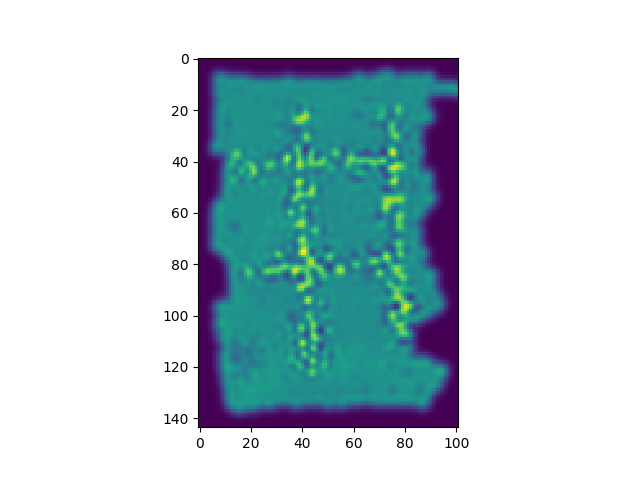

In [129]:
plt.figure()
plt.imshow(mag_z_pred)